<a href="https://www.kaggle.com/code/kursatdinc/scoutium-talent-hunting-classification?scriptVersionId=188094436" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Business Problem

According to the scores given to the characteristics of the players monitored by the scouts, the class of the (average, highlighted) predicting the player.

*Scout: A scout or talent scout is a specialized person who observes promising athletes to determine their current abilities and potential.*


# Dataset Story

The data set consists of the players evaluated by the scouts according to the characteristics of the players observed in the matches from Scoutium, the match the information includes the characteristics and scores that are scored in the score.

***scoutium_attributes.csv***

**8 Variables, 10730 Observation**

* **task_response_id:** The set of a scout's evaluations of all players in a team's squad in a match
* **match_id:** Id of the related match
* **evaluator_id:** Id of the evaluator (scout)
* **player_id:** Id of the corresponding player
* **position_id:** The id of the position the player played in that match
1: Goalkeeper
2: Stopper
3: Right back
4: Left back
5: Defensive midfield
6: Central midfield
7: Rightwing
8: Left wing
9: Offensive midfield
10: Striker
* **analysis_id:** Set containing a scout's attribute evaluations of a player in a match
* **attribute_id:** The id of each attribute on which players are evaluated
* **attribute_value:** The value (score) that a scout assigns to an attribute of a player

***scoutium_potential_labels.csv***

**5 Variables, 322 Observation**

* **ask_response_id:** The set of a scout's evaluations of all players in a team's squad in a match
* **match_id:** Id of the related match
* **evaluator_id:** Id of the evaluator (scout)
* **player_id:** Id of the corresponding player
* **potential_label:** Label indicating a scout's final decision on a player in a match (target variable)


# Importings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import warnings

warnings.filterwarnings("ignore")

# Load Dataset

In [2]:
def load():
    attributes_df = pd.read_csv("/kaggle/input/scotium/scoutium_attributes.csv", sep=";")
    potential_labels_df = pd.read_csv("/kaggle/input/scotium/scoutium_potential_labels.csv", sep=";")
    merged_df = pd.merge(attributes_df, potential_labels_df, on=["task_response_id", "match_id", "evaluator_id", "player_id"])

    return merged_df, potential_labels_df, attributes_df

merged_df, potential_labels_df, attributes_df = load()

In [3]:
attributes_df

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0
...,...,...,...,...,...,...,...,...
10725,5642,63032,151191,1909728,7,12825756,4357,67.0
10726,5642,63032,151191,1909728,7,12825756,4407,78.0
10727,5642,63032,151191,1909728,7,12825756,4408,67.0
10728,5642,63032,151191,1909728,7,12825756,4423,67.0


In [4]:
potential_labels_df

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted
...,...,...,...,...,...
317,5642,63032,151191,1367783,highlighted
318,5642,63032,151191,1369525,average
319,5642,63032,151191,1369546,average
320,5642,63032,151191,1605952,average


In [5]:
merged_df

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average
...,...,...,...,...,...,...,...,...,...
10725,5642,63032,151191,1909728,7,12825756,4357,67.0,highlighted
10726,5642,63032,151191,1909728,7,12825756,4407,78.0,highlighted
10727,5642,63032,151191,1909728,7,12825756,4408,67.0,highlighted
10728,5642,63032,151191,1909728,7,12825756,4423,67.0,highlighted


# Overview & Preprocessing

In [6]:
(merged_df[merged_df["potential_label"] == "below_average"].shape[0] * 100) / merged_df.shape[0]

1.2674743709226468

> Values with potential_label value below_average constitute 1.26% of the total data set. For this reason, I am dropping this data.

In [7]:
merged_df = merged_df[merged_df["potential_label"] != "below_average"]

> I exclude those with position_id 1 from the data set because they are Goalkeepers.

In [8]:
merged_df = merged_df[merged_df["position_id"] != 1]

In [9]:
merged_df

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average
...,...,...,...,...,...,...,...,...,...
10725,5642,63032,151191,1909728,7,12825756,4357,67.0,highlighted
10726,5642,63032,151191,1909728,7,12825756,4407,78.0,highlighted
10727,5642,63032,151191,1909728,7,12825756,4408,67.0,highlighted
10728,5642,63032,151191,1909728,7,12825756,4423,67.0,highlighted


## Creating Model Dataframe

In [10]:
pivot_table = pd.pivot_table(merged_df, index=["player_id", "position_id", "potential_label"],
                             columns=["attribute_id"], values="attribute_value")

pivot_table.reset_index(inplace=True)

In [11]:
pivot_table

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,average,67.0,78.0,78.0,56.0,78.0,67.0,78.0,...,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
267,1907347,6,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
268,1909532,10,average,56.0,45.0,45.0,45.0,56.0,56.0,56.0,...,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
269,1909724,2,highlighted,78.0,78.0,78.0,78.0,78.0,78.0,78.0,...,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


## Encoding

In [12]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe




In [13]:
label_encoder(pivot_table, "potential_label")

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,0,67.0,78.0,78.0,56.0,78.0,67.0,78.0,...,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
267,1907347,6,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
268,1909532,10,0,56.0,45.0,45.0,45.0,56.0,56.0,56.0,...,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
269,1909724,2,1,78.0,78.0,78.0,78.0,78.0,78.0,78.0,...,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


## Change Columns Types

In [14]:
pivot_table.columns = pivot_table.columns.map(str)

## Standardization

In [15]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(pivot_table, cat_th=2, car_th=20)

Observations: 271
Variables: 37
cat_cols: 0
num_cols: 37
cat_but_car: 0
num_but_cat: 0


In [17]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   player_id        271 non-null    int64  
 1   position_id      271 non-null    int64  
 2   potential_label  271 non-null    int64  
 3   4322             271 non-null    float64
 4   4323             271 non-null    float64
 5   4324             271 non-null    float64
 6   4325             271 non-null    float64
 7   4326             271 non-null    float64
 8   4327             271 non-null    float64
 9   4328             271 non-null    float64
 10  4329             271 non-null    float64
 11  4330             271 non-null    float64
 12  4332             271 non-null    float64
 13  4333             271 non-null    float64
 14  4335             271 non-null    float64
 15  4338             271 non-null    float64
 16  4339             271 non-null    float64
 17  4340            

In [18]:
num_cols = [col for col in num_cols if col not in ["player_id", "position_id", "potential_label"]]
num_cols

['4322',
 '4323',
 '4324',
 '4325',
 '4326',
 '4327',
 '4328',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4352',
 '4353',
 '4354',
 '4355',
 '4356',
 '4357',
 '4407',
 '4408',
 '4423',
 '4426']

In [19]:
scaler = StandardScaler()
pivot_table[num_cols] = scaler.fit_transform(pivot_table[num_cols])

In [20]:
pivot_table

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,...,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,...,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,...,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,0,0.595327,1.307560,1.373158,-0.064332,1.467260,0.722929,1.355461,...,0.786581,0.813645,0.428479,0.631718,0.198319,0.768231,1.201978,1.387369,1.762816,-0.252741
267,1907347,6,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,1.083267,1.041611
268,1909532,10,0,-0.163295,-0.932790,-0.710283,-0.811501,-0.021981,-0.035936,-0.153081,...,-0.760885,-0.583384,-0.195810,-1.620856,-1.234869,0.005628,-1.487277,-1.487256,-0.955381,-2.194269
269,1909724,2,1,1.353950,1.307560,1.373158,1.430006,1.467260,1.481795,1.355461,...,1.560314,1.512160,1.052769,0.631718,0.914913,0.768231,1.201978,1.387369,1.083267,1.041611


# ML Model

In [21]:
y = pivot_table["potential_label"]
X = pivot_table.drop(columns=["potential_label", "player_id"], axis=1)

## Base Models

In [22]:
def base_models(X, y, problem="cls", scoring="roc_auc", cv=3):
    if problem == "cls":
    
        print("Base Models....")
        classifiers = [("LR", LogisticRegression()),
                       ("KNN", KNeighborsClassifier()),
                       ("SVC", SVC()),
                       ("CART", DecisionTreeClassifier()),
                       ("RF", RandomForestClassifier()),
                       ("Adaboost", AdaBoostClassifier()),
                       ("GBM", GradientBoostingClassifier()),
                       ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss")),
                       ("LightGBM", LGBMClassifier(force_row_wise=True, verbose=-1)),
                       ("CatBoost", CatBoostClassifier(verbose=False))]

        for name, classifier in classifiers:
            cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
            print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name})")

    if problem == "reg":
    
        print("Base Models....")
        regressors = [("LR", LinearRegression()),
                      ("KNN", KNeighborsRegressor()),
                      ("CART", DecisionTreeRegressor()),
                      ("RF", RandomForestRegressor()),
                      ("SVM", SVR()),
                      ("XGB", XGBRegressor()),
                      ("LightGBM", LGBMRegressor(force_row_wise=True, verbose=-1)),
                      ("CatBoost", CatBoostRegressor(verbose=False))]

        for name, regressor in regressors:
            cv_results = cross_validate(regressor, X, y, cv=cv, scoring=scoring)
            print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name})")

In [23]:
base_models(X, y, problem="cls", scoring="roc_auc", cv=5)

Base Models....
roc_auc: 0.8332 (LR)
roc_auc: 0.7463 (KNN)
roc_auc: 0.8384 (SVC)
roc_auc: 0.7505 (CART)
roc_auc: 0.9082 (RF)
roc_auc: 0.8467 (Adaboost)
roc_auc: 0.8779 (GBM)
roc_auc: 0.8716 (XGBoost)
roc_auc: 0.883 (LightGBM)
roc_auc: 0.8912 (CatBoost)


> CatBoost, RF and LightGBM best 3 options

## Hyperparameter Optimization

In [24]:
catboost_params = {"iterations": [200, 500, 700],
                   "learning_rate": [0.01, 0.1, 0.2],
                   "depth": [3, 6, 9]}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}


classifiers = [("CatBoost", CatBoostClassifier(verbose=False), catboost_params),
               ("RF", RandomForestClassifier(), rf_params),
               ("LightGBM", LGBMClassifier(force_row_wise=True, verbose=-1), lightgbm_params)]

In [25]:
def hyperparameter_optimization(X, y, cv=3, models=classifiers, scoring="roc_auc"):
    
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, model, params in models:
        print(f"########## {name} ##########")
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(model, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = model.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    
    return best_models

In [26]:
best_models = hyperparameter_optimization(X, y, cv=5, models=classifiers, scoring="roc_auc")

Hyperparameter Optimization....
########## CatBoost ##########
roc_auc (Before): 0.8912
roc_auc (After): 0.8811
CatBoost best params: {'depth': 3, 'iterations': 500, 'learning_rate': 0.1}

########## RF ##########
roc_auc (Before): 0.8983


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

roc_auc (After): 0.8993
RF best params: {'max_depth': 8, 'max_features': 5, 'min_samples_split': 20, 'n_estimators': 300}

########## LightGBM ##########
roc_auc (Before): 0.883
roc_auc (After): 0.8815
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



## Voting Classifiers

In [27]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[("CatBoost", best_models["CatBoost"]),
                                              ("RF", best_models["RF"]),
                                              ("LightGBM", best_models["LightGBM"])],
                                              voting="soft").fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    
    return voting_clf

In [28]:
voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.8782491582491583
F1Score: 0.6278235294117647
ROC_AUC: 0.9015856236786469


# Feature Importances - CatBoost Model

In [29]:
catboost = CatBoostClassifier(verbose=False, random_state=42)

In [30]:
catboost_params = {"iterations": [200, 500, 700],
                   "learning_rate": [0.01, 0.1, 0.2],
                   "depth": [3, 6, 9]}

catboost_best = GridSearchCV(catboost,
                             catboost_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=True).fit(X, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [31]:
catboost_best.best_params_

{'depth': 9, 'iterations': 200, 'learning_rate': 0.1}

In [32]:
final_model = catboost.set_params(**catboost_best.best_params_).fit(X, y)

cv_results = cross_validate(final_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1-Score: {cv_results['test_f1'].mean()}")
print(f"Roc-Auc Score: {cv_results['test_roc_auc'].mean()}")

Accuracy: 0.8855892255892256
F1-Score: 0.6357142857142858
Roc-Auc Score: 0.9039112050739957


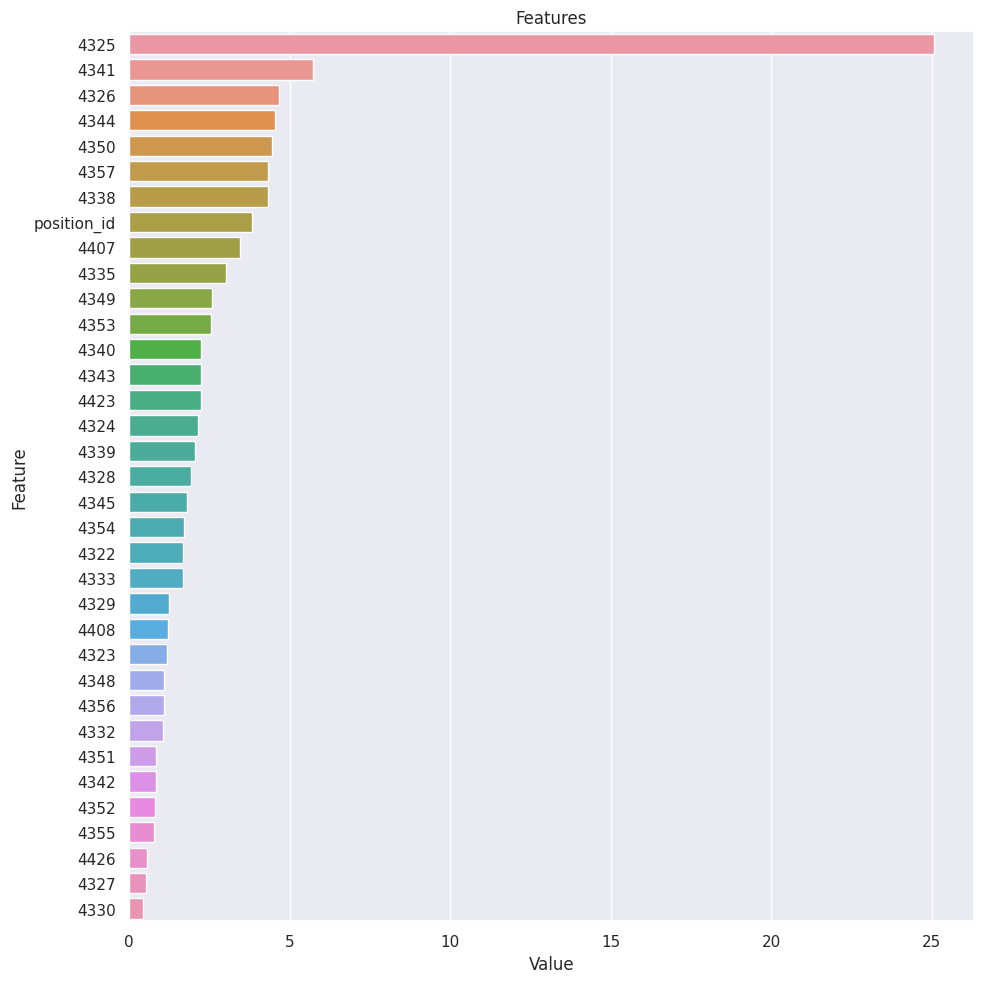

In [33]:
def plot_importance(model, features, dataframe, save=False):
    num = len(dataframe)
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

plot_importance(final_model, X, pivot_table)